In [103]:
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

#### **Dataset Loading**

In [138]:
df_raw = pd.read_csv('data/loan_2014_2015.csv')

In [139]:
df_raw.shape

(656724, 142)

In [140]:
df_raw.columns[0:20]

Index(['Unnamed: 0', 'id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'purpose'],
      dtype='object')

In [142]:
df = df_raw.copy()

In [143]:
df = df.drop(df.columns[0], axis=1)
df.shape

(656724, 141)

### Identifying the target (y)
dependent variable : "loan_status" column

In [144]:
df['loan_status'].unique()

array(['Charged Off', 'Fully Paid', 'Current', 'Late (31-120 days)',
       'Default', 'In Grace Period', 'Late (16-30 days)'], dtype=object)

**To map the subcategories**\
Fully Paid', 'Current', 'In Grace Period' is takes as Positive (i.e good loan/ paid loans) and 
rest subcategories taken as 'Bad Loans'

In [145]:
# Define the mapping
loan_status_mapping = {
    'Fully Paid': 1,
    'Current': 1,
    'In Grace Period': 1,
    'Late (16-30 days)': 0,
    'Late (31-120 days)': 0,
    'Charged Off': 0,
    'Default': 0
}

# Apply the mapping to the 'Loan_Status' column
df['loan_status_binary'] = df['loan_status'].map(loan_status_mapping)
df.drop('loan_status', axis=1, inplace=True)

df['loan_status_binary'].value_counts()

loan_status_binary
1    534795
0    121929
Name: count, dtype: int64

**Identifying the missing statistics on the features**

In [146]:
missing_df = df.isnull().sum().to_frame(name='Missing')
missing_df['Total Count'] = len(df)
missing_df['Non-Missing'] = df.count()
missing_df['Missing Percentage'] = (missing_df['Missing'] / len(df)) * 100

In [21]:
missing_df

,Missing,Total Count,Non-Missing,Missing Percentage
id,0,656724,656724,0.000000
loan_amnt,0,656724,656724,0.000000
funded_amnt,0,656724,656724,0.000000
funded_amnt_inv,0,656724,656724,0.000000
term,0,656724,656724,0.000000
...,...,...,...,...
orig_projected_additional_accrued_interest,651103,656724,5621,99.144085
hardship_payoff_balance_amount,650500,656724,6224,99.052265
hardship_last_payment_amount,650500,656724,6224,99.052265
debt_settlement_flag,0,656724,656724,0.000000


**Identifying the columns that has missing percentage of more than 50% and droping such columns**

In [147]:
missing_df = missing_df[(missing_df['Missing']>0) & (missing_df['Missing Percentage']>50)]
columns_to_drop = missing_df.index.to_list()

In [148]:
df = df.drop(columns=columns_to_drop, errors='ignore')
df.head(5)

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag,loan_status_binary
0,36805548,10400.0,10400.0,10400.0,36 months,6.99%,321.08,A,A3,Truck Driver Delivery Personel,...,14.3,0.0,0.0,179407.0,15030.0,13000.0,11325.0,N,N,0
1,38098114,15000.0,15000.0,15000.0,60 months,12.39%,336.64,C,C1,MANAGEMENT,...,0.0,0.0,0.0,196500.0,149140.0,10000.0,12000.0,N,N,1
2,37822187,9600.0,9600.0,9600.0,36 months,13.66%,326.53,C,C3,Admin Specialist,...,60.0,0.0,0.0,52490.0,38566.0,21100.0,24890.0,N,N,1
3,37612354,12800.0,12800.0,12800.0,60 months,17.14%,319.08,D,D4,Senior Sales Professional,...,100.0,0.0,0.0,368700.0,18007.0,4400.0,18000.0,N,N,1
4,37842129,21425.0,21425.0,21425.0,60 months,15.59%,516.36,D,D1,Programming Analysis Supervisor,...,100.0,0.0,0.0,57073.0,42315.0,15000.0,35573.0,N,N,1


**After significant drop columns still has missing records**

In [149]:
(pd.DataFrame(df.isnull().sum())
.reset_index()
.rename(columns={'index': 'Column', 0: 'mis_count'})
.query('mis_count > 0')
)

,Column,mis_count
9,emp_title,37110
10,emp_length,35836
18,title,132
21,dti,2
27,mths_since_last_delinq,319843
31,revol_util,287
43,last_pymnt_d,437
45,last_credit_pull_d,33
56,avg_cur_bal,6
57,bc_open_to_buy,6408


#### **Checking the datatype of columns**

**Checking the columns whose datatypes is string**

In [150]:
df.select_dtypes(include=['object']).head()

,term,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,pymnt_plan,...,zip_code,addr_state,earliest_cr_line,revol_util,initial_list_status,last_pymnt_d,last_credit_pull_d,application_type,hardship_flag,debt_settlement_flag
0,36 months,6.99%,A,A3,Truck Driver Delivery Personel,8 years,MORTGAGE,Not Verified,2014-12-01,n,...,937xx,CA,Sep-1989,31.6%,w,Aug-2016,Feb-2017,Individual,N,N
1,60 months,12.39%,C,C1,MANAGEMENT,10+ years,RENT,Source Verified,2014-12-01,n,...,235xx,VA,Aug-1994,29%,w,Jun-2016,May-2020,Individual,N,N
2,36 months,13.66%,C,C3,Admin Specialist,10+ years,RENT,Source Verified,2014-12-01,n,...,077xx,NJ,Nov-1992,59.4%,f,Apr-2015,May-2020,Individual,N,N
3,60 months,17.14%,D,D4,Senior Sales Professional,10+ years,MORTGAGE,Verified,2014-12-01,n,...,953xx,CA,Oct-2000,100.9%,w,Sep-2019,Apr-2020,Individual,N,N
4,60 months,15.59%,D,D1,Programming Analysis Supervisor,6 years,RENT,Source Verified,2014-12-01,n,...,658xx,MO,Aug-2003,76.2%,w,May-2016,Apr-2018,Individual,N,N


In [151]:
df.dtypes
dtypes_objectList = df.dtypes[df.dtypes == 'object'].index.tolist()
dtypes_objectList

['term',
 'int_rate',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'verification_status',
 'issue_d',
 'pymnt_plan',
 'url',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'earliest_cr_line',
 'revol_util',
 'initial_list_status',
 'last_pymnt_d',
 'last_credit_pull_d',
 'application_type',
 'hardship_flag',
 'debt_settlement_flag']

In [152]:
# Remove leading/trailing whitespaces from objects
df = df.apply(lambda col: col.str.strip() if col.dtypes == 'object' else col)

**Converting the columns to datetime which has string datatypes**

In [153]:
# List of columns to convert to datetime
date_columns = ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d']

# Loop over the columns and convert to datetime with the specified format
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

**Converted to datetime**

In [154]:
df['issue_d'].head(2)

0   2014-12-01
1   2014-12-01
Name: issue_d, dtype: datetime64[ns]

**Converting string numeric column to numeric after stripping unwanted characters**

In [155]:
# List of columns to convert to numeric after stripping '%' sign
percent_columns = ['int_rate', 'revol_util']

# Loop over the columns and convert them to numeric after stripping '%' sign
for col in percent_columns:
    df[col + '%'] = pd.to_numeric(df[col].str.strip('%'))


**Checking the datatype**

In [156]:
df.select_dtypes(include=['object']).head()

,term,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,pymnt_plan,url,purpose,title,zip_code,addr_state,revol_util,initial_list_status,application_type,hardship_flag,debt_settlement_flag
0,36 months,6.99%,A,A3,Truck Driver Delivery Personel,8 years,MORTGAGE,Not Verified,n,https://lendingclub.com/browse/loanDetail.acti...,credit_card,Credit card refinancing,937xx,CA,31.6%,w,Individual,N,N
1,60 months,12.39%,C,C1,MANAGEMENT,10+ years,RENT,Source Verified,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,235xx,VA,29%,w,Individual,N,N
2,36 months,13.66%,C,C3,Admin Specialist,10+ years,RENT,Source Verified,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,077xx,NJ,59.4%,f,Individual,N,N
3,60 months,17.14%,D,D4,Senior Sales Professional,10+ years,MORTGAGE,Verified,n,https://lendingclub.com/browse/loanDetail.acti...,car,Car financing,953xx,CA,100.9%,w,Individual,N,N
4,60 months,15.59%,D,D1,Programming Analysis Supervisor,6 years,RENT,Source Verified,n,https://lendingclub.com/browse/loanDetail.acti...,credit_card,Credit card refinancing,658xx,MO,76.2%,w,Individual,N,N


In [157]:
# No of columns with 'object' dtype
df.select_dtypes(include=['object']).shape[1]

19

In [158]:
df.select_dtypes(include=['datetime']).head(2)

,issue_d,earliest_cr_line,last_pymnt_d,last_credit_pull_d
0,2014-12-01,1989-09-01,2016-08-01,2017-02-01
1,2014-12-01,1994-08-01,2016-06-01,2020-05-01


In [160]:
df.select_dtypes(include=['datetime']).shape[1]

4

In [161]:
df.select_dtypes(include=['number']).head(2)

,id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,loan_status_binary,int_rate%,revol_util%
0,36805548,10400.0,10400.0,10400.0,321.08,58000.0,14.92,0.0,710.0,714.0,...,14.3,0.0,0.0,179407.0,15030.0,13000.0,11325.0,0,6.99,31.6
1,38098114,15000.0,15000.0,15000.0,336.64,78000.0,12.03,0.0,750.0,754.0,...,0.0,0.0,0.0,196500.0,149140.0,10000.0,12000.0,1,12.39,29.0


In [162]:
# No of columns with 'object' dtype
df.select_dtypes(include=['number']).shape[1]

72

In [163]:
df.shape

(656724, 95)

In [164]:
df['title'].unique()

array(['Credit card refinancing', 'Debt consolidation', 'Car financing',
       ..., 'New Baby and New House (CC Consolidate)',
       'Credit Card/Auto Repair', 'Student Loan'], dtype=object)

In [39]:
df['pymnt_plan']

0         n
1         n
2         n
3         n
4         n
         ..
656719    n
656720    n
656721    n
656722    n
656723    n
Name: pymnt_plan, Length: 656724, dtype: object

#### **Checking for columns than can be drop using various approach**

**Selecting and droping some columns with less/no importance**

In [168]:
columns_to_drop = {'title','zip_code','pymnt_plan', 'emp_title','int_rate','revol_util', 'url'}
df.drop(columns_to_drop, axis = 1, inplace = True, errors='ignore')

**checking and droping columns have low variance**

In [169]:
low_variance_cols = []

for col in df.select_dtypes(include=['number']).columns:
    var = df[col].var()
    if var < 0.05:
        low_variance_cols.append(col)

low_variance_cols    

['collections_12_mths_ex_med',
 'policy_code',
 'acc_now_delinq',
 'chargeoff_within_12_mths',
 'num_tl_120dpd_2m',
 'num_tl_30dpd']

In [170]:
df.drop(low_variance_cols, axis = 1, inplace = True)

In [171]:
df.shape

(656724, 82)

**Making copy of df to further processing**

In [172]:
df_01 = df.copy()

**Droping the rows having missing values**

In [173]:
df_01.dropna(inplace=True)

In [174]:
df_01.shape

(283134, 82)

#### **Working on Categorical Variables**

In [175]:
categorical_column = df_01.select_dtypes(include=['object', 'category', 'bool']).columns
categorical_column

Index(['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'verification_status', 'purpose', 'addr_state', 'initial_list_status',
       'application_type', 'hardship_flag', 'debt_settlement_flag'],
      dtype='object')

In [176]:
for category in categorical_column:
    print(f"df_01['{category}'].value_counts()")

df_01['term'].value_counts()
df_01['grade'].value_counts()
df_01['sub_grade'].value_counts()
df_01['emp_length'].value_counts()
df_01['home_ownership'].value_counts()
df_01['verification_status'].value_counts()
df_01['purpose'].value_counts()
df_01['addr_state'].value_counts()
df_01['initial_list_status'].value_counts()
df_01['application_type'].value_counts()
df_01['hardship_flag'].value_counts()
df_01['debt_settlement_flag'].value_counts()


**Checking the value counts on columns**

In [177]:
# df_01['term'].value_counts()
# df_01['grade'].value_counts()
# df_01['sub_grade'].value_counts()
# df_01['emp_length'].value_counts()
# df_01['home_ownership'].value_counts()
# df_01['verification_status'].value_counts()
# df_01['purpose'].value_counts()
# df_01['addr_state'].value_counts()
# df_01['initial_list_status'].value_counts()
# df_01['application_type'].value_counts()
# df_01['hardship_flag'].value_counts()
df_01['debt_settlement_flag'].value_counts()

debt_settlement_flag
N    274790
Y      8344
Name: count, dtype: int64

**Performing various encoding methods like one-hot econding, label-econding, WoE encoding, etc for the purpose to change the categorical to numerical and droping the columns by reducing the number of columns** 

In [178]:
df_01.debt_settlement_flag = np.where(df_01.debt_settlement_flag == 'Y',1,0)

In [179]:
df_01.term_36_months = np.where(df_01.term == '36 months',1,0)
df_01.drop('term', axis=1, inplace=True, errors='ignore')

In [180]:
df_01['emp_length'] = df['emp_length'].fillna('')

In [181]:
df_01['emp_length'] = pd.to_numeric(df['emp_length'].str
                                 .replace('<', '', regex=False).str[:2].str.strip(), errors='coerce')

In [182]:
# Replaces both actual NaN values and string 'NaN' values in the hardship_flag column with 'N'.
df_01.hardship_flag.fillna('N', inplace=True) #it looks like the Nans are as strings so
df_01.hardship_flag = np.where( df_01.hardship_flag == 'NaN','N', df_01.hardship_flag )

**Checking all the categorical columns having different datatype**

In [183]:
categorical_column = df_01.select_dtypes(include=['object', 'category', 'bool']).columns
categorical_column

Index(['grade', 'sub_grade', 'home_ownership', 'verification_status',
       'purpose', 'addr_state', 'initial_list_status', 'application_type',
       'hardship_flag'],
      dtype='object')

**Identifying all the unique entries for each categorical column to check the possibility of encoding**

In [57]:
# Get the number of unique entries(or sub categories) in each categorical column
object_nunique = {col: df_01[col].nunique() for col in categorical_column}
object_nunique   

{'grade': 7,
 'sub_grade': 35,
 'home_ownership': 4,
 'verification_status': 3,
 'purpose': 14,
 'addr_state': 50,
 'initial_list_status': 2,
 'application_type': 2,
 'hardship_flag': 2}

In [184]:
# Convert to DataFrame and sort by unique counts
unique_counts = pd.DataFrame(list(object_nunique.items()), columns=['Column', 'Unique Count'])
unique_counts = unique_counts.sort_values(by='Unique Count').reset_index(drop=True)

In [59]:
unique_counts

,Column,Unique Count
0,initial_list_status,2
1,application_type,2
2,hardship_flag,2
3,verification_status,3
4,home_ownership,4
5,grade,7
6,purpose,14
7,sub_grade,35
8,addr_state,50


In [185]:
df_01.head(5)

,id,loan_amnt,funded_amnt,funded_amnt_inv,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,...,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag,loan_status_binary,int_rate%,revol_util%
0,36805548,10400.0,10400.0,10400.0,321.08,A,A3,8.0,MORTGAGE,58000.0,...,0.0,179407.0,15030.0,13000.0,11325.0,N,0,0,6.99,31.6
3,37612354,12800.0,12800.0,12800.0,319.08,D,D4,10.0,MORTGAGE,125000.0,...,0.0,368700.0,18007.0,4400.0,18000.0,N,0,1,17.14,100.9
4,37842129,21425.0,21425.0,21425.0,516.36,D,D1,6.0,RENT,63800.0,...,0.0,57073.0,42315.0,15000.0,35573.0,N,0,1,15.59,76.2
6,37800722,12975.0,12975.0,12975.0,468.17,D,D5,10.0,RENT,60000.0,...,0.0,42943.0,17281.0,5500.0,27243.0,N,0,0,17.86,33.1
7,36804663,23325.0,23325.0,23325.0,800.71,C,C4,10.0,RENT,72000.0,...,0.0,443889.0,79490.0,36000.0,78126.0,N,0,0,14.31,82.2


Key observations¶
sub_grade : is already grupped by grade

home_wnership : The majority categories (mortgage and rent) dominate the data, while own and especially other are underrepresented. Such an imbalance can lead to biased models, where predictions are skewed toward the majority classes.

purpose : here is huge imbalance, especialy on medical, car, small_business, vacation, moving, house, renewable_energy, wedding, educational. It should be grouped

addr_state : as well

**Droping the 'sub_grade' columns because it is already grupped by 'grade' column**\
**In 'home_ownership' column the majority categories (mortgage and rent) dominate the data**\
**in 'purpose' column has hude imbalance in its category especialy on medical, car, small_business, vacation, moving, house, renewable_energy, wedding, educational. It should be grouped**\
**In 'addr_state' column as well**

In [186]:
df_01.drop('sub_grade', axis=1, inplace = True, errors = 'ignore') 

In [187]:
df_01.shape

(283134, 80)

#### **Using WoE & IV for categorical features and calculating Information (IV) value to filter out the important features amoong all the categorical features.**

In [188]:
def process_categorical_columns(df, categorical_cols, target_col, woe_table=None, iv_summary=None, append=False):
    """
    Calculate WoE and IV for given categorical columns, including NaNs as a separate category.
    
    Args:
        df (pd.DataFrame): Input DataFrame.
        categorical_cols (list): List of categorical column names to process.
        target_col (str): Name of the binary target column (1 = Good, 0 = Bad).
        woe_table (pd.DataFrame): Existing WoE table (required if append=True).
        iv_summary (pd.DataFrame): Existing IV summary (required if append=True).
        append (bool): If True, append results to existing tables.
    
    Returns:
        woe_table (pd.DataFrame): WoE table with all processed columns.
        iv_summary (pd.DataFrame): IV summary table with all processed columns.
    """
    if append and (woe_table is None or iv_summary is None):
        raise ValueError("Existing tables must be provided when append=True.")
    
    # Initialize results if not appending
    if not append:
        woe_table = pd.DataFrame()
        iv_summary = pd.DataFrame()
    
    new_woe_results = []
    new_summary = []

    # Process each categorical column
    for col in categorical_cols:
        # Handle NaN values by creating a separate 'NaN' category
        df[col] = df[col].fillna('NaN')
        
        # Group by the column to calculate metrics
        stats = df.groupby(col).agg(
            event_count=(target_col, 'sum'),
            total_count=(target_col, 'count')
        ).reset_index()

        # Calculate non-event count and proportions
        stats['non_event_count'] = stats['total_count'] - stats['event_count']
        total_events = stats['event_count'].sum()
        total_non_events = stats['non_event_count'].sum()

        # Avoid division by zero
        stats['event_rate'] = stats['event_count'] / (total_events + 1e-6)
        stats['non_event_rate'] = stats['non_event_count'] / (total_non_events + 1e-6)

        # Calculate WoE
        stats['woe'] = np.log((stats['non_event_rate'] + 1e-6) / (stats['event_rate'] + 1e-6))
        
        # Calculate IV for each category
        stats['iv'] = (stats['non_event_rate'] - stats['event_rate']) * stats['woe']
        
        # Compute total IV for the column
        total_iv = stats['iv'].sum()

        # Add column name and rename for desired format
        stats['name'] = col  # Add column name
        stats.rename(columns={col: 'sub_name'}, inplace=True)  # Rename column to 'sub_name'
        
        # Reorder columns
        stats = stats[['name', 'sub_name', 'event_count', 'total_count', 'non_event_count', 
                       'event_rate', 'non_event_rate', 'woe', 'iv']]

        # Append results
        new_woe_results.append(stats)
        new_summary.append({'Column': col, 'IV': total_iv})

    # Combine results with existing tables if appending
    new_woe_table = pd.concat(new_woe_results, ignore_index=True)
    new_iv_summary = pd.DataFrame(new_summary).sort_values(by='IV', ascending=False)

    if append:
        woe_table = pd.concat([woe_table, new_woe_table], ignore_index=True)
        iv_summary = pd.concat([iv_summary, new_iv_summary], ignore_index=True).sort_values(by='IV', ascending=False)
    else:
        woe_table = new_woe_table
        iv_summary = new_iv_summary

    return woe_table, iv_summary

**WoE and IV summary table**

In [189]:
# Initial processing
categorical_cols = df_01.select_dtypes(include=['object']).columns
woe_table, iv_summary = process_categorical_columns(df_01, categorical_cols, 'loan_status_binary')

iv_summary

,Column,IV
0,grade,0.393105
2,verification_status,0.046403
1,home_ownership,0.027622
3,purpose,0.019707
4,addr_state,0.015719
7,hardship_flag,0.007815
5,initial_list_status,0.000507
6,application_type,0.000016


**Droping the columns having IV below 0.02**

In [190]:
#dropping where IV < 0.02
drop= {'application_type','initial_list_status','emp_length','hardship_flag','addr_state','purpose'}
df_01.drop(drop, axis=1, inplace=True, errors='ignore')

In [193]:
df_01.shape

(283134, 74)

**Checking the Categorical Variables in the original and later dataframe**

In [194]:
# no. of columns with 'object' dtype
df.select_dtypes(include=['object']).shape[1]

12

In [196]:
df_01.select_dtypes(include=['object']).shape[1]

3

**A look of WoE table for different features**

In [198]:
print("WoE Table:")
woe_table[woe_table.name == 'hardship_flag']

WoE Table:


,name,sub_name,event_count,total_count,non_event_count,event_rate,non_event_rate,woe,iv
82,hardship_flag,N,227474,282466,54992,0.997111,0.999836,0.002729,0.000007
83,hardship_flag,Y,659,668,9,0.002889,0.000164,-2.865175,0.007808


In [199]:
print("WoE Table:")
woe_table[woe_table.name == 'verification_status']

WoE Table:


,name,sub_name,event_count,total_count,non_event_count,event_rate,non_event_rate,woe,iv
11,verification_status,Not Verified,67218,78560,11342,0.294644,0.206214,-0.356850,0.031556
12,verification_status,Source Verified,103164,129533,26369,0.452210,0.479428,0.058446,0.001591
13,verification_status,Verified,57751,75041,17290,0.253146,0.314358,0.216564,0.013256


In [200]:
print("WoE Table:")
woe_table[woe_table.name == 'home_ownership']

WoE Table:


,name,sub_name,event_count,total_count,non_event_count,event_rate,non_event_rate,woe,iv
7,home_ownership,ANY,3,3,0,0.000013,0.00000,-2.649730,0.000035
8,home_ownership,MORTGAGE,126146,152222,26076,0.552949,0.47410,-0.153847,0.012131
9,home_ownership,OWN,22137,27559,5422,0.097036,0.09858,0.015792,0.000024
10,home_ownership,RENT,79847,103350,23503,0.350002,0.42732,0.199593,0.015432


**Mapping categories espicially for imbalance subcategory of home_ownership**

In [201]:
home_ownership_mapping = {
    'ANY' : 'other',
    'MORTGAGE' : 'other',
    'RENT' : 'rent',
    'OWN' : 'own'
}
df_01.home_ownership = df_01.home_ownership.map(home_ownership_mapping)

**Total categorical variable ready for the final dataset**

In [202]:
object_columns = df_01.select_dtypes(include=['object']).columns
object_columns

Index(['grade', 'home_ownership', 'verification_status'], dtype='object')

**Visualization of categorical variable w.r.t the target 'loan_status_binary'**

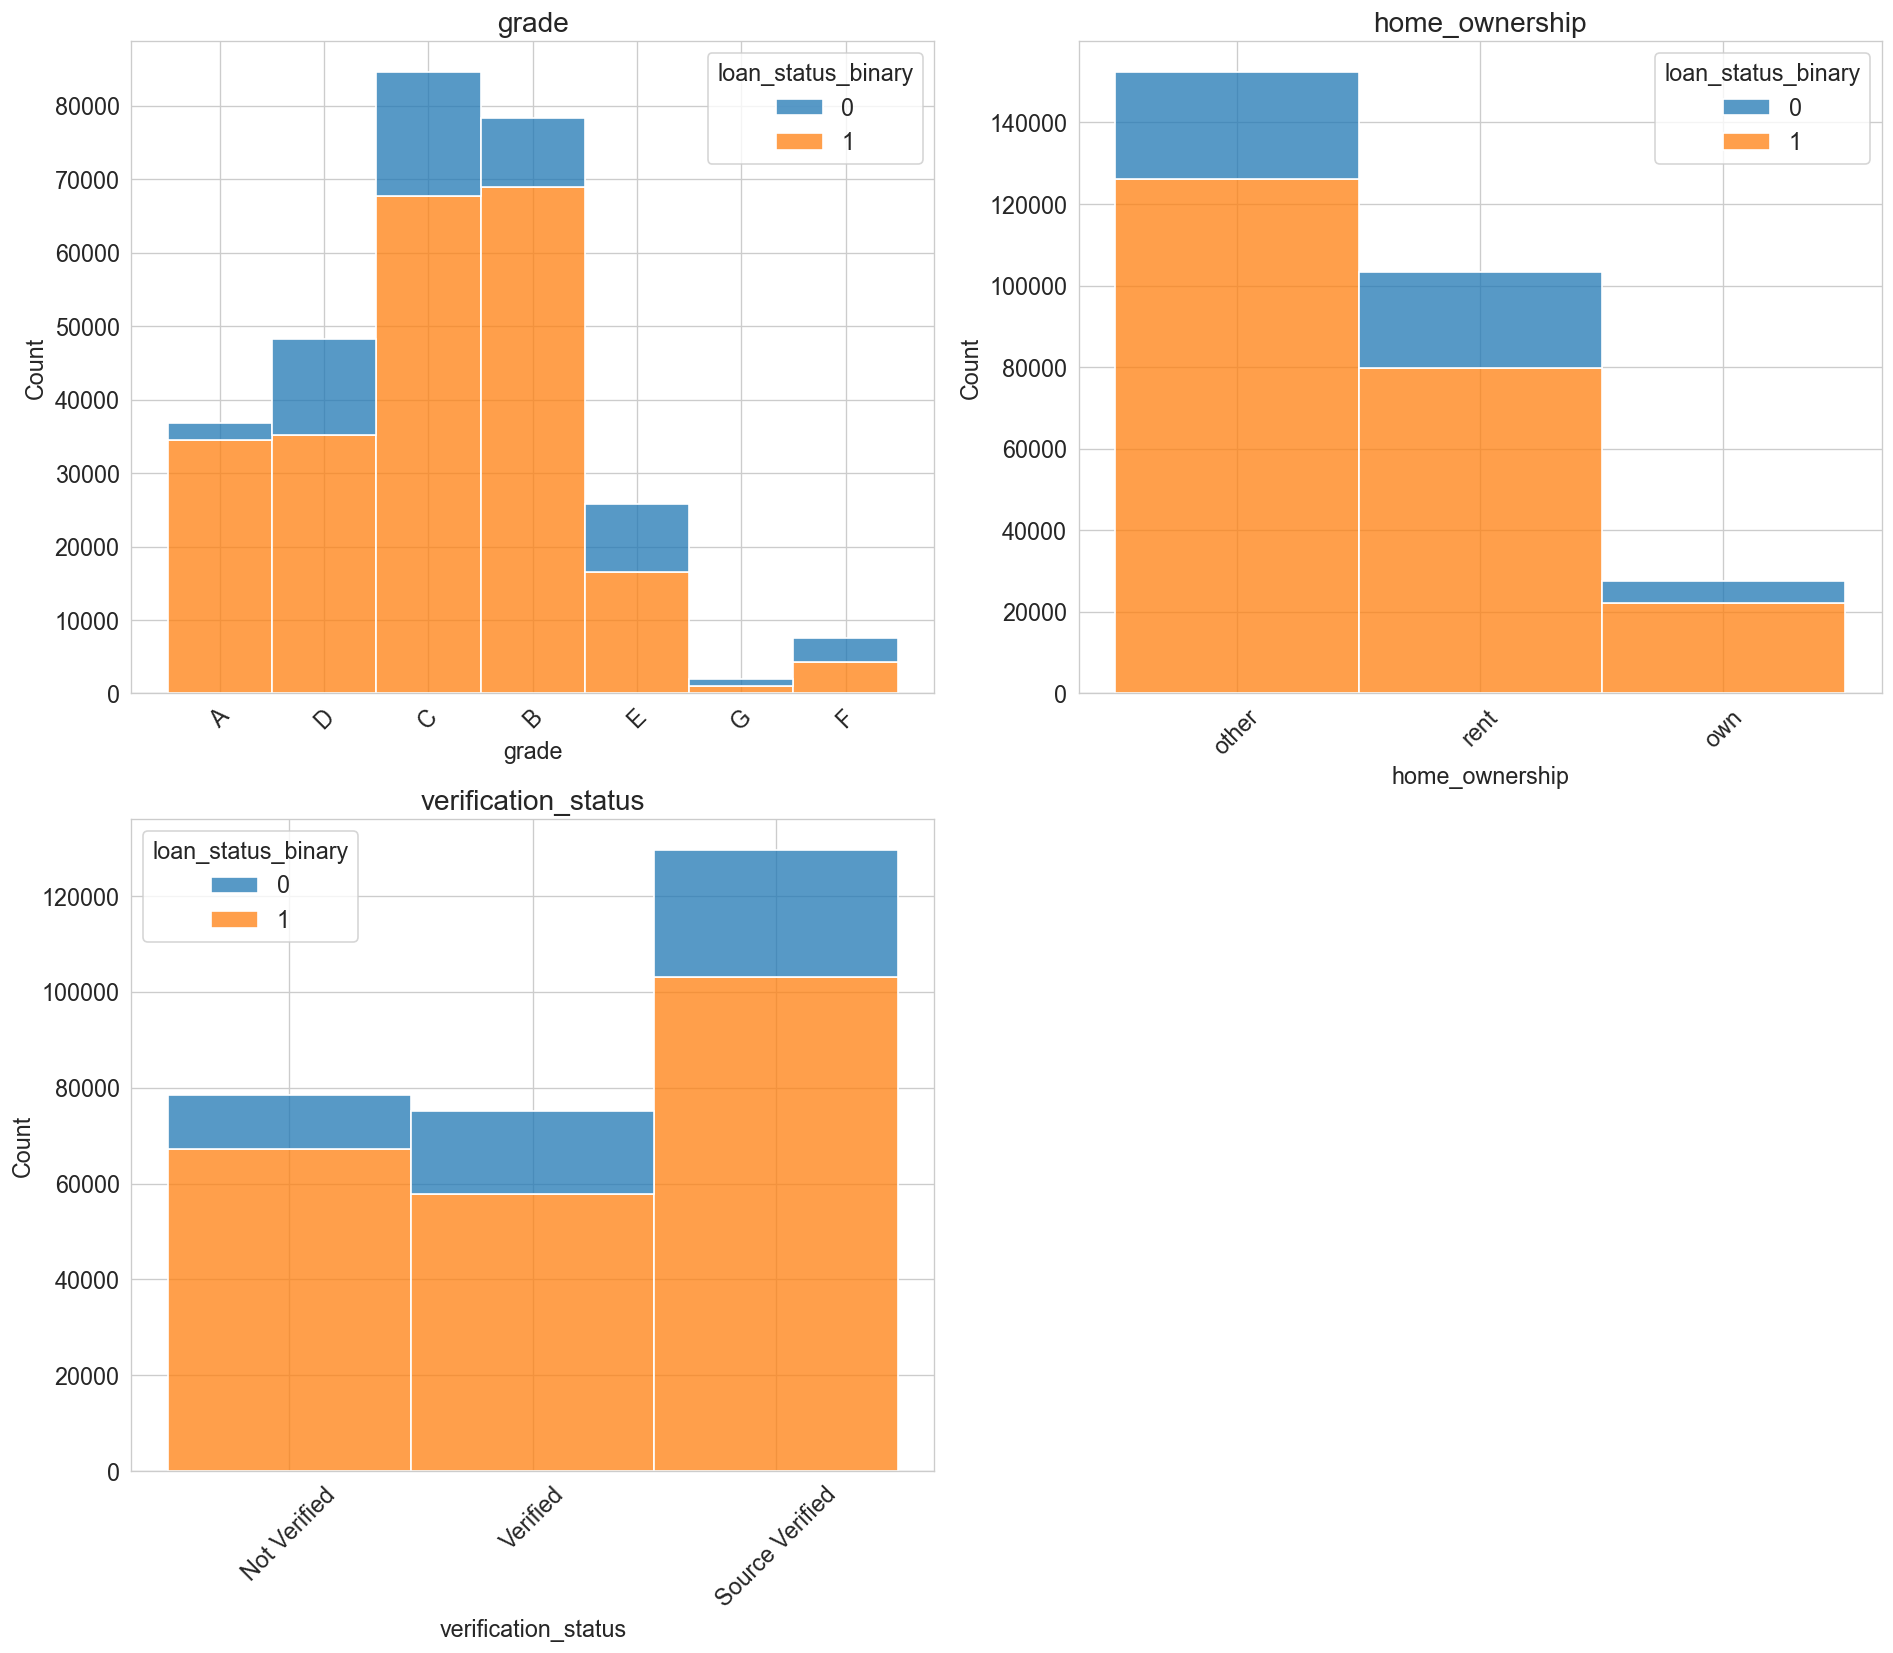

In [207]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select object columns
object_columns = df_01.select_dtypes(include=['object']).columns

# Setup figure
fig, axes = plt.subplots(2, 2, figsize=(16, 14))  # Fixed 2x2 grid
axes = axes.flatten()

# Simple plotting
for i, col in enumerate(object_columns):
    df_01[col] = df_01[col].fillna('NaN')  # Handle missing values
    sns.histplot(
        data=df_01,
        x=col,
        hue='loan_status_binary',
        multiple='stack',
        ax=axes[i]
    )
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=45)

# Clean up empty subplots
for j in range(len(object_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [208]:
df_01.shape

(283134, 74)

#### **Working on Datetime variable**

What Each Feature Means:
loan_age_days - How old the loan is (newer loans may behave differently)

credit_history_years - Borrower's experience with credit before this loan

days_since_last_payment - How recently payments were made (late = riskier)

days_since_credit_check - How recently lender checked credit

made_recent_payment? - Simple yes(1)/no(0) flag for recent activity

recent_credit_check? - Yes(1)/no(0) flag for recent lender checks

In [213]:
df_02 = df_01.copy()

In [214]:
dateTime_column = df_02.select_dtypes(include=['datetime']).columns
dateTime_column

Index(['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d'], dtype='object')

In [ ]:
import pandas as pd
from datetime import datetime

# 1. Setting today's date (for calculating time differences)
today = pd.to_datetime("today")

# 2. Handling missing dates - assume they mean "just happened"
date_columns = ['last_pymnt_d', 'last_credit_pull_d']
for col in date_columns:
    df_02[col] = df_02[col].fillna(today)  # Treating missing dates as today

# 3. Creating time-based features (in days)
df_02['loan_age_days'] = (today - df_02['issue_d']).dt.days          # Days since loan was issued
df_02['credit_history_years'] = (df_02['issue_d'] - df_02['earliest_cr_line']).dt.days / 365  # Years of credit history
df_02['time_since_last_payment'] = (today - df_02['last_pymnt_d']).dt.days
df_02['time_since_last_credit_pull'] = (today - df_02['last_credit_pull_d']).dt.days

# 4. Creating simple yes/no flags
df_02['made_recent_payment?'] = (df_02['time_since_last_payment'] <= 30).astype(int)  # 1 if paid in last 30 days
df_02['recent_credit_check?'] = (df_02['time_since_last_credit_pull'] <= 90).astype(int)   # 1 if checked in last 90 days

# 5. Drop original date columns (we've extracted what we need)
df_02.drop(['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d'], axis=1, inplace=True)

In [216]:
df_02.shape

(283134, 76)

#### **Working on Numerical Variables**

In [217]:
df_03 = df_02.copy()

In [218]:
y = df_03.loan_status_binary
cat_cols = df_03.select_dtypes(include=['object']).columns
num_cols = df_03.select_dtypes(exclude=['object']).drop('loan_status_binary',axis=1).columns

# Concatenate numeric columns explicitly
df_04 = pd.concat([df_03[num_cols], pd.get_dummies(df_03[cat_cols], drop_first=True)], axis=1)

In [219]:
df_04.columns

Index(['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'installment',
       'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high',
       'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec',
       'revol_bal', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'last_fico_range_high', 'last_fico_range_low',
       'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
       'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
       'mths_since_recent_bc', 'mths_since_recent_inq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_tl

**Droping numerical columns that are not reliable**

In [220]:
external_scores = {'last_fico_range_high','last_fico_range_low','fico_range_low', 'fico_range_high'}
df_04.drop(external_scores , axis=1, inplace=True)
df_04.drop('id', axis=1, inplace=True)

In [221]:
df_04.shape

(283134, 77)

**checking the numerical columns**

In [222]:
columnList_numerical = df_04.select_dtypes(include=['number']).columns

**visualizing the distribution of numerical variables**

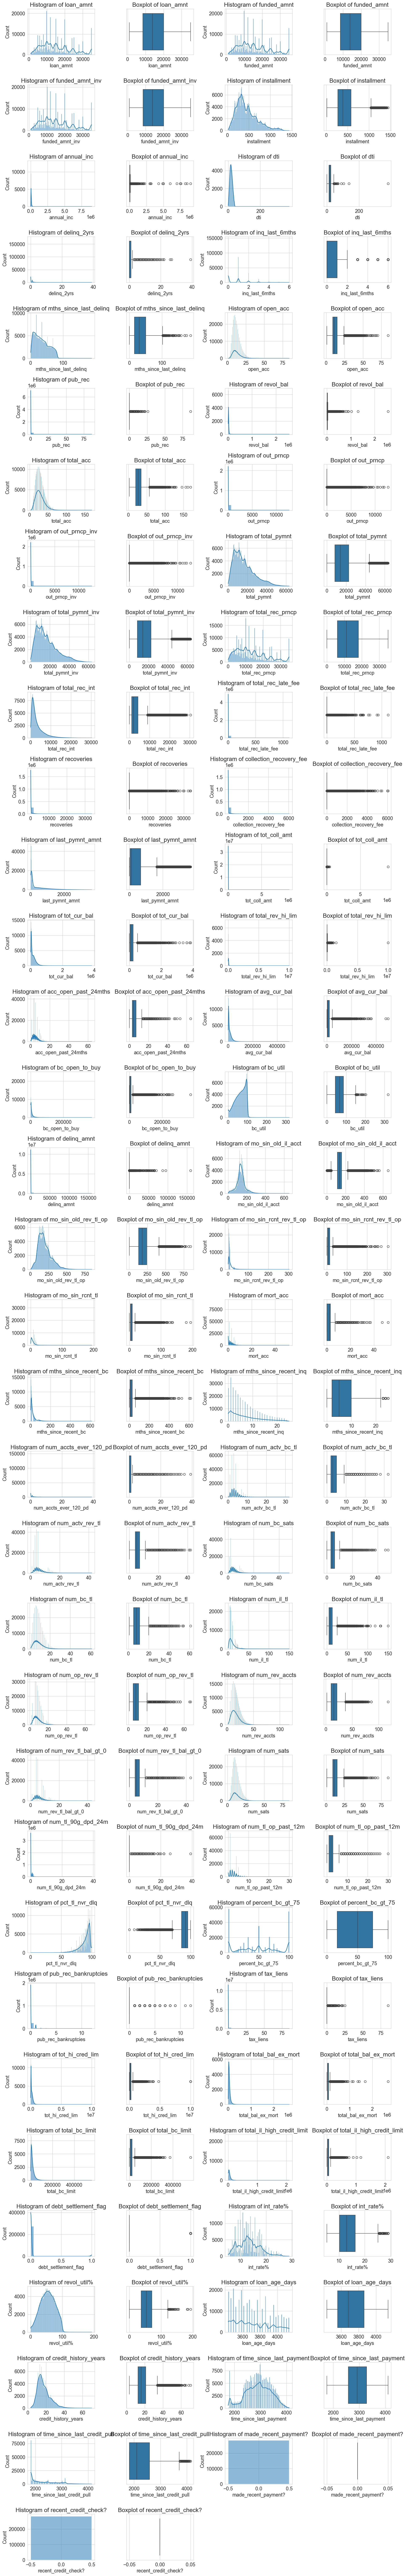

In [223]:
# Number of rows and columns
ncols = 4 
nrows = len(columnList_numerical)

fig , ax = plt.subplots(nrows,ncols, figsize=(ncols *4, nrows * 3)) #dynamically providing the figsize
ax = ax.flatten()

for i, col in enumerate(columnList_numerical):
    ax_index_hist = i * 2  # Histogram index
    ax_index_box = i * 2 + 1  # Boxplot index
    sns.histplot(data= df_04, x=col, kde=True, ax=ax[ax_index_hist])
    ax[ax_index_hist].set_title(f'Histogram of {col}')  # Title for histogram
    ax[ax_index_hist].set_xlabel(col)

    sns.boxplot(data=df_04, x=col, ax=ax[ax_index_box])
    ax[ax_index_box].set_title(f'Boxplot of {col}')  # Title for boxplot
    ax[ax_index_box].set_xlabel(col)  # X-axis label

# Hide unused subplots if there are extra axes
for j in range(len(columnList_numerical)*2, len(ax)):
    ax[j].set_visible(False)

plt.tight_layout()
plt.show()

In [225]:
df_04.shape

(283134, 77)

**checking the corelation of features with target variable**

In [226]:
correlationMatrix = df_04.corrwith(y).abs()
correlationMatrix

loan_amnt                              0.063914
funded_amnt                            0.063914
funded_amnt_inv                        0.063851
installment                            0.046333
annual_inc                             0.038451
                                         ...   
grade_G                                0.059178
home_ownership_own                     0.002061
home_ownership_rent                    0.063537
verification_status_Source Verified    0.021614
verification_status_Verified           0.054870
Length: 77, dtype: float64

In [227]:
# Converting to DataFrame and sort
correlation_df = correlationMatrix.sort_values(ascending=False).reset_index()
correlation_df.columns = ['name', 'correlation']

# Displaying the resulting DataFrame
correlation_df.head(30)

,name,correlation
0,recoveries,0.540366
1,collection_recovery_fee,0.528579
2,total_rec_prncp,0.421110
3,time_since_last_credit_pull,0.356645
4,debt_settlement_flag,0.354839
5,last_pymnt_amnt,0.313987
6,total_pymnt_inv,0.271750
7,total_pymnt,0.271720
8,int_rate%,0.241170
9,time_since_last_payment,0.194861


**Still there are 77 features which is too high. Now performing feature selection to select the important features only**

#### **Feature Selection**

In [228]:
feature_corr = df_04.corr()

In [229]:
print(plt.colormaps())

['magma', 'inferno', 'plasma', 'viridis', 'cividis', 'twilight', 'twilight_shifted', 'turbo', 'Blues', 'BrBG', 'BuGn', 'BuPu', 'CMRmap', 'GnBu', 'Greens', 'Greys', 'OrRd', 'Oranges', 'PRGn', 'PiYG', 'PuBu', 'PuBuGn', 'PuOr', 'PuRd', 'Purples', 'RdBu', 'RdGy', 'RdPu', 'RdYlBu', 'RdYlGn', 'Reds', 'Spectral', 'Wistia', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd', 'afmhot', 'autumn', 'binary', 'bone', 'brg', 'bwr', 'cool', 'coolwarm', 'copper', 'cubehelix', 'flag', 'gist_earth', 'gist_gray', 'gist_heat', 'gist_ncar', 'gist_rainbow', 'gist_stern', 'gist_yarg', 'gnuplot', 'gnuplot2', 'gray', 'hot', 'hsv', 'jet', 'nipy_spectral', 'ocean', 'pink', 'prism', 'rainbow', 'seismic', 'spring', 'summer', 'terrain', 'winter', 'Accent', 'Dark2', 'Paired', 'Pastel1', 'Pastel2', 'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c', 'grey', 'gist_grey', 'gist_yerg', 'Grays', 'magma_r', 'inferno_r', 'plasma_r', 'viridis_r', 'cividis_r', 'twilight_r', 'twilight_shifted_r', 'turbo_r', 'Blues_r', 'BrBG_r', '

**Visualizing in heatmap**

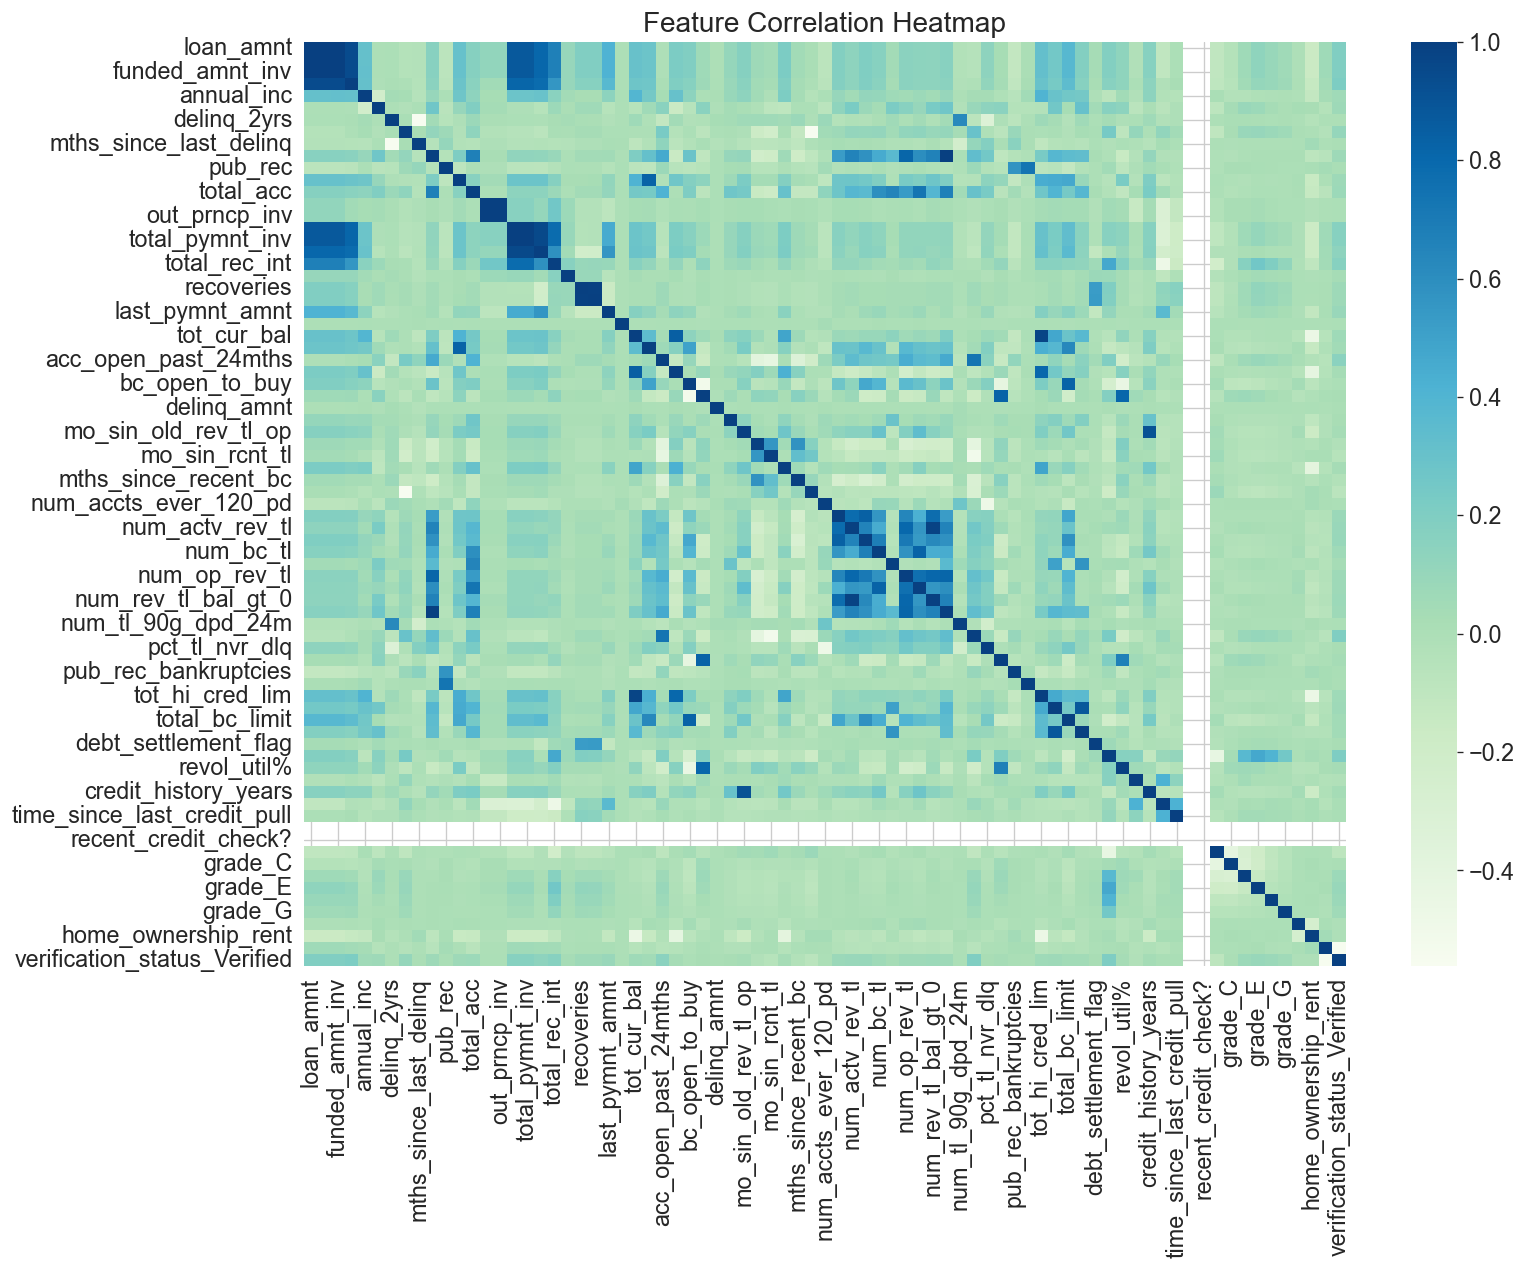

In [230]:
import seaborn as sns
# Heat map
fig = plt.figure(figsize=(14,10))
sns.heatmap(feature_corr, annot=False, cmap=plt.colormaps()[13])
plt.title("Feature Correlation Heatmap")
plt.show()

In [231]:
df_04.shape

(283134, 77)

**Now performing feature selection using mutual_info_regression library that calculates mutual information between the features and target. Only the feature having high mutual information with the target variable is selected for the model training process**\
**12 features were selected for further processing**

In [232]:
from sklearn.feature_selection import mutual_info_regression

# First calculating the mutual information scores for regression using mutual_info_regression
informationGain_scores = mutual_info_regression(df_04, y)

# Creating a DataFrame to display feature importance based on information gain
informationGain_scores_df = pd.DataFrame({'Feature': df_04.columns, 'Information Gain': informationGain_scores})

# Sorting features by importance (descending)
informationGain_scores_df = informationGain_scores_df.sort_values(by='Information Gain', ascending=False)

# selecting top 12 features from the informationGain_scores_df
selected_feature_df= informationGain_scores_df.nlargest(12, 'Information Gain').sort_index(axis=0)

# Print selected features
print("Selected important features based on Information Gain for Regression:")
print(selected_feature_df)

Selected important features based on Information Gain for Regression:
                        Feature  Information Gain
3                   installment          0.023362
15                  total_pymnt          0.067447
16              total_pymnt_inv          0.066966
17              total_rec_prncp          0.436382
19           total_rec_late_fee          0.021780
20                   recoveries          0.326867
21      collection_recovery_fee          0.325250
22              last_pymnt_amnt          0.276874
58         debt_settlement_flag          0.049366
59                    int_rate%          0.031083
63      time_since_last_payment          0.030433
64  time_since_last_credit_pull          0.117789


**Saving the selected features with the target variable to a new csv file or dataset for the model training**

In [233]:
# Save df_final to a CSV file
df_final = df_04[selected_feature_df['Feature']]
df_final['loan_status_binary'] = y
# df_final.to_csv("data/df_2014-15_selected.csv", index=False)